In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

C:\Users\STA Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching Cats and Dogs dataset...

In [2]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

In [3]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32
IMAGE_RES = 224

num_examples = info.splits['train'].num_examples

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [4]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

In [5]:
feature_extractor.trainable = False

In [6]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

582/582 [==============================] - 1169s 2s/step - loss: 0.0536 - accuracy: 0.9812 - val_loss: 0.0370 - val_accuracy: 0.9886


In [8]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [9]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog',
       'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [10]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0]
Predicted labels:  [0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0]


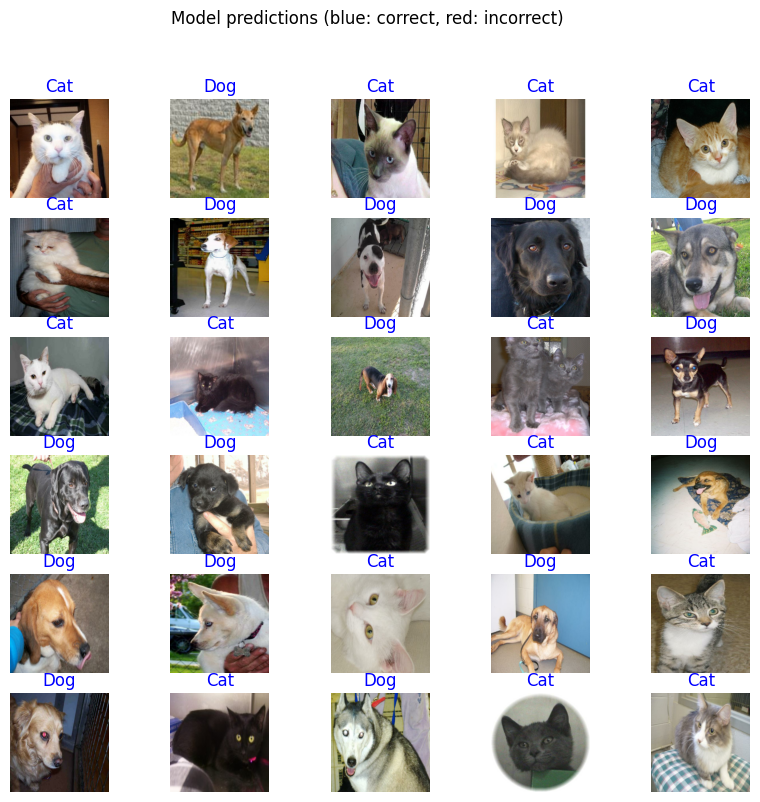

In [11]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [15]:
name = "cats_and_dogs"

# export_path_keras = "./{}.h5".format(name)
# print(export_path_keras)

model.save(name)

INFO:tensorflow:Assets written to: cats_and_dogs\assets


INFO:tensorflow:Assets written to: cats_and_dogs\assets
